medical_example_aiub.ipynb.py  
Copyright (C) 2023 Elodie Escriva, Kaduceo <elodie.escriva@kaduceo.com>  

This program is free software: you can redistribute it and/or modify  
it under the terms of the GNU General Public License as published by  
the Free Software Foundation; either version 3 of the License, or  
(at your option) any later version.  
  
This program is distributed in the hope that it will be useful,  
but WITHOUT ANY WARRANTY; without even the implied warranty of  
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the  
GNU General Public License for more details.  

You should have received a copy of the GNU General Public License  
along with this program.  If not, see <https://www.gnu.org/licenses/>.  

**Disclaimer**  
The results may differ from those presented in the articles mentioned, as the models and explanations produced are not identical.  
This notebook is an example of the use of local attributive explanations.

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

import openml as oml

import sklearn_extra
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import silhouette_score

import graphviz

In [2]:
import utils
import metrics
import clustering_methods

In [3]:
pd.set_option("max_colwidth", None)
import warnings
warnings.filterwarnings('ignore')

## Dataset

**[Acute Inflammations Data Set](https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations)**  
The main idea of this data set is to prepare the algorithm of the expert system, which will perform the presumptive diagnosis of diseases of urinary system.
Acute inflammation of urinary bladder is characterised by sudden occurrence of pains in the abdomen region and the urination in form of constant urine pushing, micturition pains and sometimes lack of urine keeping. Temperature of the body is rising, however most often not above 38C. The excreted urine is turbid and sometimes bloody. At proper treatment, symptoms decay usually within several days. However, there is inclination to returns. At persons with acute inflammation of urinary bladder, we should expect that the illness will turn into protracted form.
Each instance represents an potential patient.

*Citation:*  J.Czerniak, H.Zarzycki, Application of rough sets in the presumptive diagnosis of urinary system diseases, Artifical Inteligence and Security in Computing Systems, ACS'2002 9th International Conference Proceedings, Kluwer Academic Publishers, 2003, pp. 41-51. https://doi.org/10.1007/978-1-4419-9226-0_5

In [4]:
dataset = oml.datasets.get_dataset(1556)

X, y, _, _ = dataset.get_data(
    dataset_format='dataframe',
    target=dataset.default_target_attribute
)

In [5]:
columns_rename = {'V1': 'Temperature of patient',
                  'V2': 'Occurrence of nausea',
                  'V3': 'Lumbar pain',
                  'V4': 'Urine pushing',
                  'V5': 'Micturition pains',
                  'V6': 'Burning of urethra, itch, swelling of urethra outlet'}

X.rename(columns_rename, axis=1, inplace=True)
X.replace({"no":0, "yes":1}, inplace=True)
X = X.astype("float")

In [6]:
y.name = 'Inflammation of urinary bladder'
y.replace({"no":0, "yes":1}, inplace=True)

## Modelling

In [9]:
xtrain, xtest, ytrain, ytest = sk.model_selection.train_test_split(X, y, random_state=2)

In [10]:
model = utils.fct_XGB_gridsearch(X, y)

In [12]:
model.fit(xtrain.values, ytrain.values)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='error', feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [13]:
preds = model.predict(X)
preds_proba = pd.DataFrame(model.predict_proba(X))

In [14]:
model.score(xtest.values, ytest)

0.8666666666666667

## Explanations

In [15]:
treeshap_influences = utils.TreeSHAP_oneclass(model, X)

In [16]:
kernelshap_influences = utils.KernelSHAP_oneclass(model, X)

  0%|          | 0/120 [00:00<?, ?it/s]

In [17]:
lime_influences = utils.LIME_oneclass(model, X)

## Global Clustering

These steps are related to the ones from our paper accepted in the [ADBIS 2023 conference](https://www.essi.upc.edu/dtim/ADBIS2023/index.html) : "How to make the most of local explanations: effective clustering based on influences".  

In this paper, we hypothesise that influences can be seen as a new data space that can be explored and used as a basis for further analysis. Indeed, influences provide new information thanks to ML modelling, which considers complex phenomena and interactions.
Influence analysis can thus help identify the main trends of explanations, i.e. the characteristic relationships between the attributes. Also, it can be interesting to provide a global view of the explanations to determine whether instances are typical or atypical cases of the data.
In this direction, an influence-based clustering approach is a good candidate since it can be the most straightforward approach to detect more homogeneous subgroups of influences and understand the behaviour of the modelling and the underlying dataset.

In [19]:
list_percentages = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

With 120 patients in the dataset, the number of clusters will be as following :  
|Percentage |0.01|0.02|0.03|0.04|0.05|0.1|0.2|0.3|0.4|0.5|
|-----------|----|----|----|----|----|---|---|---|---|---|
|Nb clusters|2|2|4|5|6|12|24|36|48|60|

In [20]:
raw_clusters = clustering_methods.cluster_multiple_percentage(X, list_percentages)
treeshap_clusters = clustering_methods.cluster_multiple_percentage(treeshap_influences, list_percentages)
kernelshap_clusters = clustering_methods.cluster_multiple_percentage(kernelshap_influences, list_percentages)
lime_clusters = clustering_methods.cluster_multiple_percentage(lime_influences, list_percentages)

### Metrics

In [21]:
list_methods = ["Raw", "TreeSHAP", "KernelSHAP", "LIME"]

In [22]:
markers = ['s-r', 'p-k', 'o-b', '*-g']

#### Internal Metric : Silhouette Score

In [23]:
raw_silscore = {p:silhouette_score(X, raw_clusters[p].labels_) for p in list_percentages}
treeshap_silscore = {p:silhouette_score(treeshap_influences, treeshap_clusters[p].labels_) for p in list_percentages}
kernelshap_silscore = {p:silhouette_score(kernelshap_influences, kernelshap_clusters[p].labels_) for p in list_percentages}
lime_silscore = {p:silhouette_score(lime_influences, lime_clusters[p].labels_) for p in list_percentages}

In [24]:
silscore_metric = pd.DataFrame(columns=list_methods)

In [25]:
silscore_metric["Raw"] = raw_silscore
silscore_metric["TreeSHAP"] = treeshap_silscore
silscore_metric["KernelSHAP"] = kernelshap_silscore
silscore_metric["LIME"] = lime_silscore

In [26]:
silscore_metric

,Raw,TreeSHAP,KernelSHAP,LIME
0.01,0.570754,0.676739,0.725327,0.709245
0.02,0.570754,0.676739,0.725327,0.709245
0.03,0.352962,0.710307,0.760787,0.697922
0.04,0.417053,0.789679,0.815375,0.717677
0.05,0.460519,0.871996,0.888782,0.745377
0.10,0.567980,0.940603,0.938745,0.311243
0.20,0.579361,0.866667,0.658333,0.174847
0.30,0.569393,0.866667,0.600000,0.165423
0.40,0.570343,0.866667,0.600000,0.155060
0.50,0.507783,0.866667,0.600000,0.143175


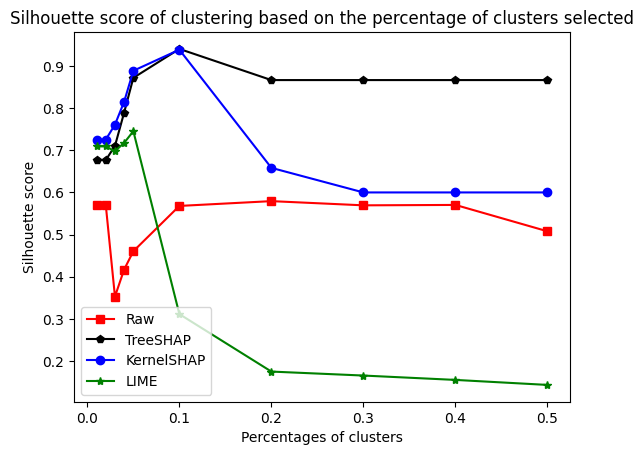

In [27]:
silscore_metric.plot.line(style=markers,
                         title='Silhouette score of clustering based on the percentage of clusters selected', 
                         xlabel='Percentages of clusters', ylabel='Silhouette score')
plt.show()

#### External Metrics : Purity & Entropy

In [28]:
raw_metrics = {p:metrics.compute_clusters_purity_entropy(raw_clusters[p].labels_, y) for p in list_percentages}
treeshap_metrics = {p:metrics.compute_clusters_purity_entropy(treeshap_clusters[p].labels_, y) for p in list_percentages}
kernelshap_metrics = {p:metrics.compute_clusters_purity_entropy(kernelshap_clusters[p].labels_, y) for p in list_percentages}
lime_metrics = {p:metrics.compute_clusters_purity_entropy(lime_clusters[p].labels_, y) for p in list_percentages}

In [29]:
purity_metric = pd.DataFrame(columns = list_methods)
entropy_metric = pd.DataFrame(columns = list_methods)

for p in list_percentages :
    purity_metric.loc[p, "Raw"] = raw_metrics[p][0]
    purity_metric.loc[p, "TreeSHAP"] = treeshap_metrics[p][0]
    purity_metric.loc[p, "KernelSHAP"] = kernelshap_metrics[p][0]
    purity_metric.loc[p, "LIME"] = lime_metrics[p][0]
    
    entropy_metric.loc[p, "Raw"] = raw_metrics[p][1]
    entropy_metric.loc[p, "TreeSHAP"] = treeshap_metrics[p][1]
    entropy_metric.loc[p, "KernelSHAP"] = kernelshap_metrics[p][1]
    entropy_metric.loc[p, "LIME"] = lime_metrics[p][1]

In [30]:
display(purity_metric)
display(entropy_metric)

,Raw,TreeSHAP,KernelSHAP,LIME
0.01,0.333333,0.408333,0.408333,0.408333
0.02,0.333333,0.408333,0.408333,0.408333
0.03,0.658333,0.666667,0.741667,0.833333
0.04,0.725,0.758333,0.758333,0.758333
0.05,0.691667,0.916667,0.916667,0.916667
0.10,0.916667,0.958333,0.958333,0.9
0.20,0.966667,0.991667,0.991667,0.991667
0.30,0.975,0.991667,0.991667,0.975
0.40,0.983333,0.991667,0.991667,0.975
0.50,0.991667,0.991667,0.991667,0.991667


,Raw,TreeSHAP,KernelSHAP,LIME
0.01,0.55387,0.30094,0.322799,0.322799
0.02,0.55387,0.30094,0.322799,0.322799
0.03,0.49969,0.234351,0.0,0.234351
0.04,0.447615,0.234351,0.234351,0.234351
0.05,0.398769,0.0,0.0,0.0
0.10,0.0,0.0,0.0,0.0
0.20,0.0,0.0,0.0,0.0
0.30,0.0,0.0,0.0,0.0
0.40,0.0,0.0,0.0,0.0
0.50,0.0,0.0,0.0,0.0


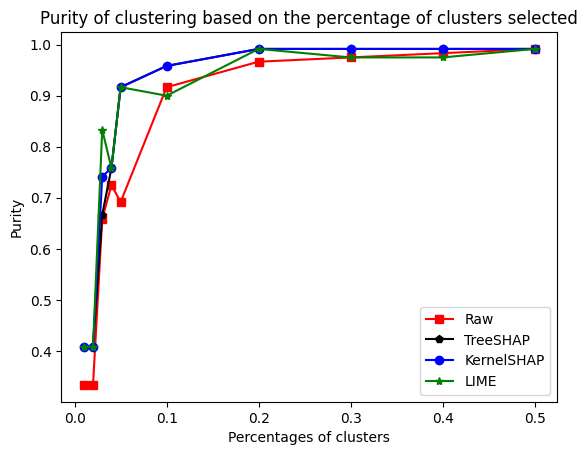

In [31]:
purity_metric.plot.line(style=markers,
                        title='Purity of clustering based on the percentage of clusters selected', 
                        xlabel='Percentages of clusters', ylabel='Purity')
plt.show()

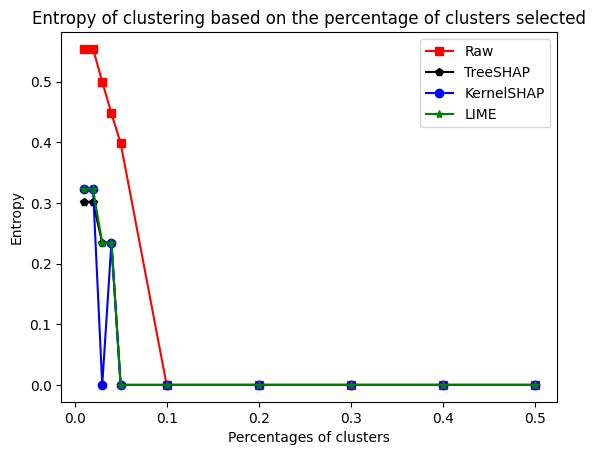

In [32]:
entropy_metric.plot.line(style=markers,
                        title='Entropy of clustering based on the percentage of clusters selected', 
                        xlabel='Percentages of clusters', ylabel='Entropy')
plt.show()

## Exploring local explanations

These steps are related to the ones from our paper accepted in the [EXEC-MAN](https://sites.google.com/view/exec-man)/[AIDMA](https://www.essi.upc.edu/dtim/ADBIS2023/index.html?p=workshops#aidma) 2023 workshop, host in the ADBIS conference : "Data exploration based on local attribution explanation: a medical use case".  

In this paper, our objective was to apply a bottom-up exploratory data analysis approach on a medical dataset, on both explanations and raw data, to highlight and compare the knowledge retrieved in both data spaces. We showed that explanations can allow a deeper dataset investigation and the usefulness of seeing explanations not only as an outcome but also as a tool, a new data space.

In [33]:
#Searching the best number of clusters for both raw data and TreeSHAP influences spaces, based on the silhouette score

list_raw_silscore = []
list_xai_silscore = []

for k in range(2,20):
    kmedoid = sklearn_extra.cluster.KMedoids(n_clusters=k,
                                            metric='euclidean',
                                            init='heuristic',
                                            method='pam',
                                            max_iter=10000, 
                                            random_state=6)
    kmedoid.fit(X)
    list_raw_silscore.append(sk.metrics.silhouette_score(X=X, labels=kmedoid.labels_, metric='euclidean').round(2))
    
    kmedoid.fit(treeshap_influences)
    list_xai_silscore.append(sk.metrics.silhouette_score(X=treeshap_influences, labels=kmedoid.labels_, metric='euclidean').round(2))
    

In [34]:
df_silscore = pd.DataFrame(list(zip(list_raw_silscore, list_xai_silscore)), 
                           columns =['Raw', 'XAI'],
                           index=range(2,20))

In [35]:
df_silscore.T

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Raw,0.57,0.44,0.37,0.42,0.46,0.51,0.54,0.54,0.56,0.57,0.56,0.56,0.57,0.58,0.59,0.58,0.58,0.58
XAI,0.68,0.62,0.71,0.79,0.87,0.96,0.93,0.93,0.93,0.94,0.96,0.95,0.95,0.95,0.95,0.95,0.95,0.95


In [49]:
n_raw = 16
n_xai = 7

In [50]:
kmedoids_raw = sklearn_extra.cluster.KMedoids(n_clusters=n_raw,
                                            metric='euclidean',
                                            init='heuristic',
                                            method='pam',
                                            max_iter=10000, 
                                            random_state=6)

kmedoids_raw.fit(X)

KMedoids(max_iter=10000, method='pam', n_clusters=16, random_state=6)

In [51]:
kmedoids_xai = sklearn_extra.cluster.KMedoids(n_clusters=n_xai,
                                            metric='euclidean',
                                            init='heuristic',
                                            method='pam',
                                            max_iter=10000, 
                                            random_state=6)

kmedoids_xai.fit(treeshap_influences)

KMedoids(max_iter=10000, method='pam', n_clusters=7, random_state=6)

#### Decision Tree

In [52]:
dtc = DecisionTreeClassifier()
Xtrain, Xtest, ytrain, ytest = sk.model_selection.train_test_split(X, y, random_state=6)
dtc.fit(Xtrain, ytrain)

dtc.score(Xtest, ytest)

0.9333333333333333

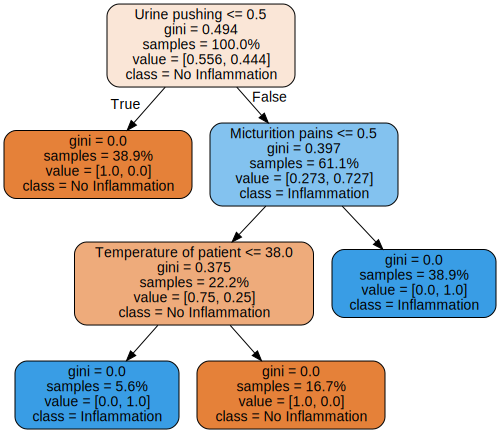

In [153]:
dot_data = sk.tree.export_graphviz(dtc, out_file=None, 
                                feature_names=X.columns,  
                                class_names=["No Inflammation", "Inflammation"],  
                                filled=True, rounded=True,
                                proportion=True,
                                special_characters=False)  
graph = graphviz.Source(dot_data)  
graph

#### Clusters Rules

In [54]:
df_skrules_raw = clustering_methods.clustering_skoperules(X, kmedoids_raw.labels_, max_depth=5)
df_skrules_raw

,Cluster,Rule,Precision,Recall
0,0,"Temperature of patient <= 37.14999961853027 and Temperature of patient > 36.44999885559082 and Burning of urethra, itch, swelling of urethra outlet > 0.5",1.0,1.0
1,1,"Occurrence of nausea > 0.5 and Urine pushing > 0.5 and Burning of urethra, itch, swelling of urethra outlet <= 0.5",1.0,1.0
2,2,Temperature of patient <= 37.14999961853027 and Temperature of patient > 36.39999961853027 and Urine pushing <= 0.5,1.0,1.0
3,3,"Temperature of patient <= 39.55000114440918 and Temperature of patient > 38.39999961853027 and Micturition pains <= 0.5 and Burning of urethra, itch, swelling of urethra outlet > 0.5",1.0,1.0
4,4,Lumbar pain <= 0.5 and Urine pushing <= 0.5,1.0,1.0
5,5,Temperature of patient <= 38.89999961853027 and Temperature of patient > 37.14999961853027 and Urine pushing <= 0.5,1.0,1.0
6,6,"Occurrence of nausea > 0.5 and Burning of urethra, itch, swelling of urethra outlet > 0.5",1.0,1.0
7,7,Temperature of patient <= 38.95000076293945 and Lumbar pain <= 0.5 and Micturition pains <= 0.5,1.0,1.0
8,8,Occurrence of nausea > 0.5 and Urine pushing <= 0.5,1.0,1.0
9,9,"Temperature of patient <= 38.39999961853027 and Lumbar pain > 0.5 and Burning of urethra, itch, swelling of urethra outlet > 0.5",1.0,1.0


In [55]:
df_skrules_xai = clustering_methods.clustering_skoperules(X, kmedoids_xai.labels_, max_depth=5)
df_skrules_xai

,Cluster,Rule,Precision,Recall
0,0,Lumbar pain <= 0.5 and Micturition pains > 0.5,1.0,1.0
1,1,"Micturition pains <= 0.5 and Burning of urethra, itch, swelling of urethra outlet > 0.5",1.0,1.0
2,2,Occurrence of nausea > 0.5 and Urine pushing <= 0.5,1.0,1.0
3,3,Occurrence of nausea > 0.5 and Urine pushing > 0.5,1.0,1.0
4,4,Temperature of patient <= 38.95000076293945 and Lumbar pain <= 0.5 and Micturition pains <= 0.5,1.0,1.0
5,5,Lumbar pain <= 0.5 and Urine pushing <= 0.5,1.0,1.0
6,6,Temperature of patient <= 38.95000076293945 and Urine pushing <= 0.5,1.0,1.0


#### Instance Selection

In [56]:
dico_rename = {'Temperature of patient': 'Temperature\nof patient', 
               'Occurrence of nausea': 'Occurrence\nof nausea', 
               'Lumbar pain': 'Lumbar pain',
               'Urine pushing': 'Urine pushing', 
               'Micturition pains': 'Micturition pains',
               'Burning of urethra, itch, swelling of urethra outlet': 'Burning of urethra, itch,\nswelling of urethra outlet'}

In [57]:
def plot_shap_unique_obs(prediction, var_series, influences_series, 
                         nb_var, axe_, var_order=None, rename_dico=None, put_var_name=True,
                         fontsize_title=12, title=None):
    
    if var_order is None :
        liste_variables_ordonnees = influences_series.abs().sort_values(ascending=False).index.to_list()[:nb_var][::-1]
    else :
        liste_variables_ordonnees = var_order[ :nb_var ][::-1]

    index_series_plot = [i + " - " + str(int(var_series[i]))  for i in liste_variables_ordonnees]
    
    if rename_dico is not None :
        index_series_plot = [rename_dico[i] + " - " + str(int(var_series[i]))  for i in liste_variables_ordonnees]
    
    if not put_var_name :
        index_series_plot = [ " - ".join((x.split(" - ")[0][0], x.split(" - ")[1])) for x in index_series_plot ]
        
    
    mon_barh_plot = axe_.barh(index_series_plot, influences_series[liste_variables_ordonnees].values)

    for i, nom_i in enumerate(liste_variables_ordonnees) :
        couleur_plot = "red"
        if influences_series.loc[nom_i] < 0 :
            couleur_plot = "limegreen"
    
        mon_barh_plot[i].set_color(couleur_plot)
        mon_barh_plot[i].set_alpha(1)
        
    if title is None :
        axe_.set_title("Aggravation prediction of " + str(prediction) + "%", fontsize=fontsize_title)
    else :
        axe_.set_title(title, fontsize=fontsize_title)

In [150]:
def plot_infs_selected_instances(datas, preds_proba, infs, inst_indexes, variables, rename_dico, title_glob=None) :
    nb_variables = None

    plus_ = 0.5
    min_ = infs.iloc[inst_indexes].min().min() - plus_
    max_ = infs.iloc[inst_indexes].max().max() + plus_

    nb_line = round(len(inst_indexes)/4)
    fig, ax = plt.subplots( nb_line, 4, figsize=(15, 4.5*nb_line), squeeze=False)

    for i in range(nb_line*4) :
        x_, y_ = i//4, i%4

        
        if i >= len(inst_indexes) :
            ax[x_, y_].axis("off")
            continue

        pred_i = (preds_proba[1] * 100).round(1).iloc[inst_indexes].iloc[i]
        title = "Cluster n°" + str(i+1) + ": Instance n°" + str(inst_indexes[i])+ "\n" 
        title += "Prediction of AIUB = " + r"$\mathbf{" + str(pred_i) + r"\%}$"
        
        put_var_name = y_ == 0

        plot_shap_unique_obs(pred_i, 
                             datas[variables].iloc[inst_indexes].iloc[i],
                             infs.iloc[inst_indexes].iloc[i], 
                             nb_variables, ax[x_, y_], variables, rename_dico, put_var_name,
                             fontsize_title=10, title=title)

        ax[x_, y_].tick_params(axis="both", labelsize=9)
        ax[x_, y_].set_axisbelow(True)
        ax[x_, y_].grid(axis="x", linewidth=0.6, linestyle="-")
        ax[x_, y_].grid(axis="y", linewidth=0.9, linestyle="--")
        ax[x_, y_].set_xticks(np.arange(-50, 50, 5))
        ax[x_, y_].plot([0, 0], [-1, 22], "-", color="black", linewidth=1.5)
        ax[x_, y_].set_ylim([-0.5, 5.5])
        ax[x_, y_].set_xlim((min_, max_))

    if title_glob :
        fig.suptitle(title_glob, fontsize=18)

    fig.show()

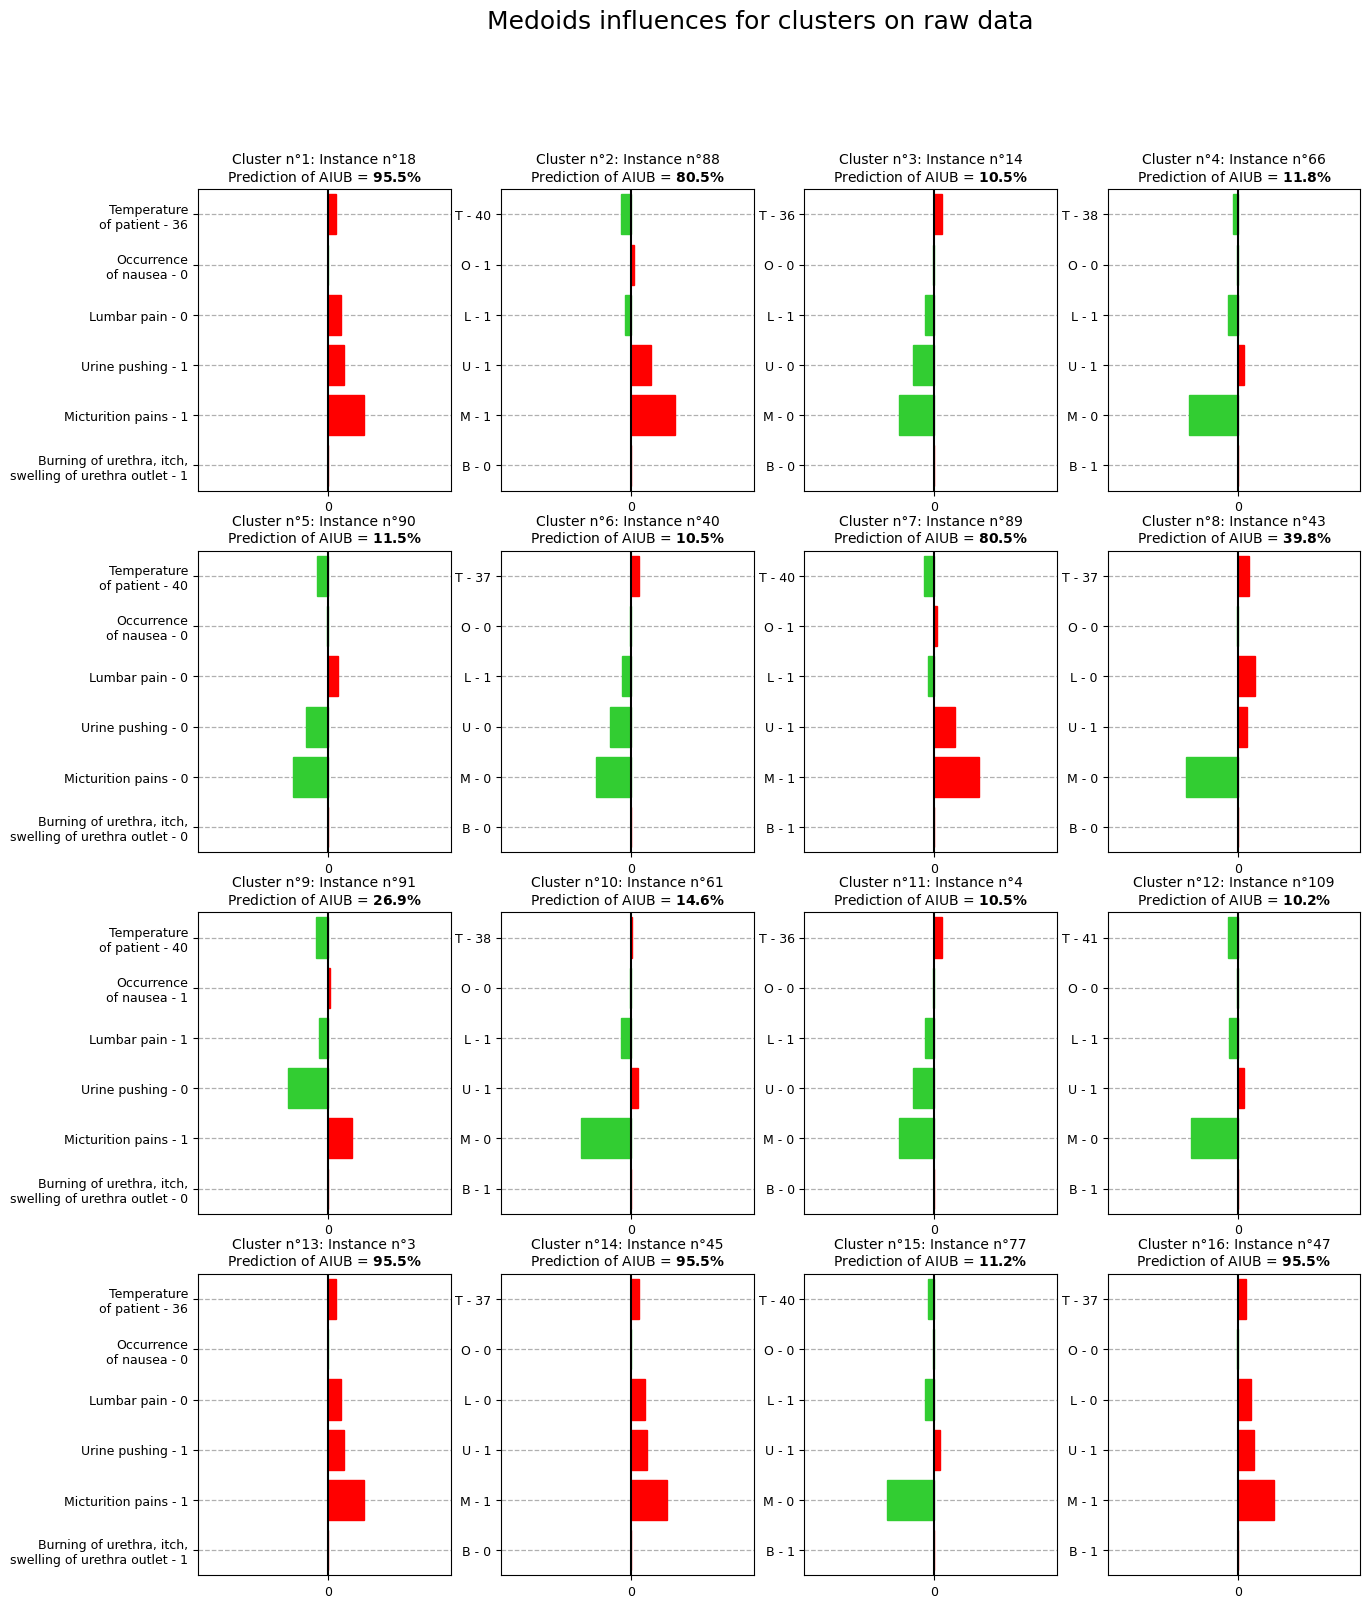

In [151]:
plot_infs_selected_instances(X, preds_proba, treeshap_influences, kmedoids_raw.medoid_indices_, X.columns, 
                             dico_rename, title_glob="Medoids influences for clusters on raw data")

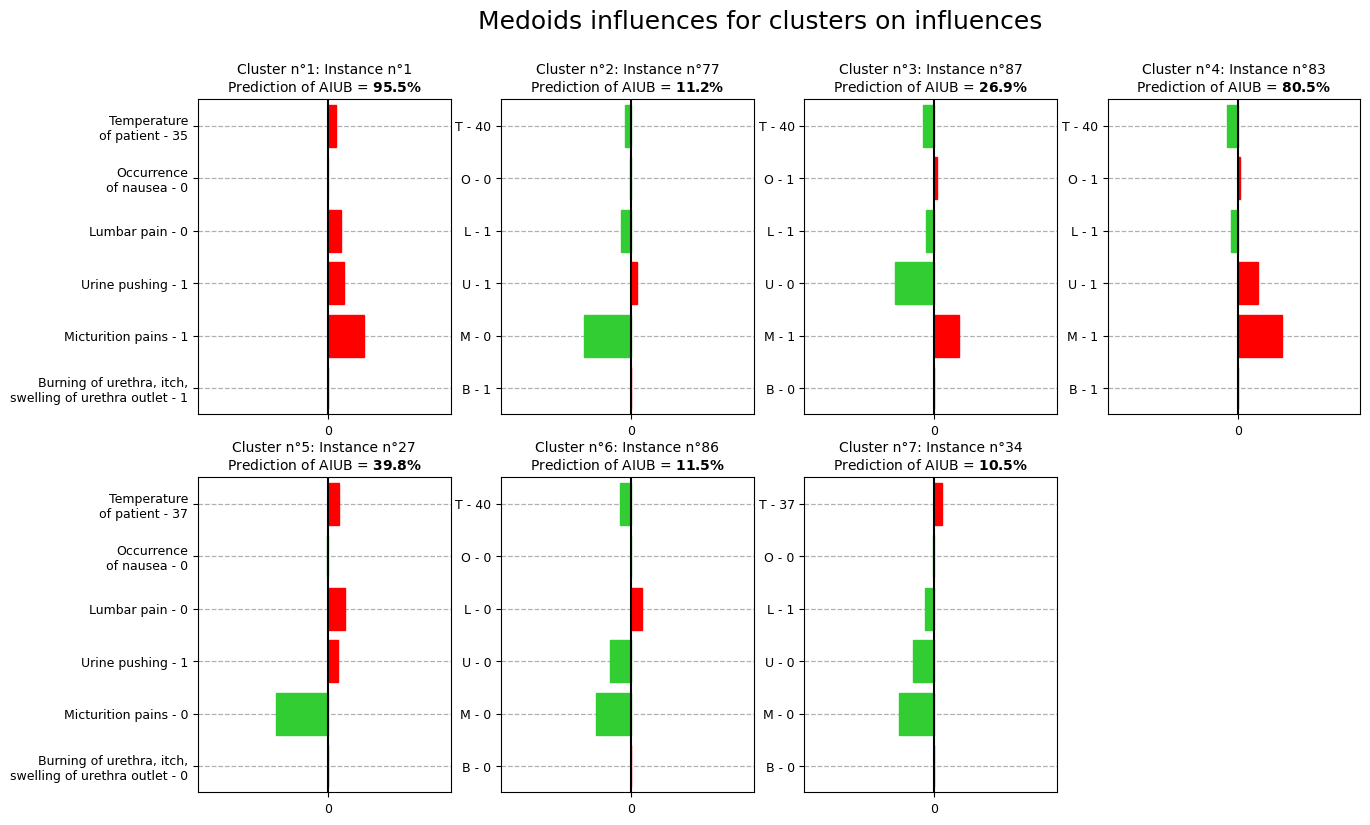

In [152]:
plot_infs_selected_instances(X, preds_proba, treeshap_influences, kmedoids_xai.medoid_indices_, X.columns, 
                             dico_rename, title_glob="Medoids influences for clusters on influences")